# Gradient-boosting decision tree (GBDT)

In this notebook, we will present the gradient boosting decision tree
algorithm and contrast it with AdaBoost.

Gradient-boosting differs from AdaBoost due to the following reason: instead
of assigning weights to specific samples, GBDT will fit a decision tree on
the residuals error (hence the name "gradient") of the previous tree.
Therefore, each new tree in the ensemble predicts the error made by the
previous learner instead of predicting the target directly.

In this section, we will provide some intuition about the way learners are
combined to give the final prediction. In this regard, let's go back to our
regression problem which is more intuitive for demonstrating the underlying
machinery.

In [1]:
import pandas as pd
import numpy as np

# Create a random number generator that will be used to set the randomness
rng = np.random.RandomState(0)


def generate_data(n_samples=50):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_max, x_min = 1.4, -1.4
    len_x = x_max - x_min
    x = rng.rand(n_samples) * len_x - len_x / 2
    noise = rng.randn(n_samples) * 0.3
    y = x ** 3 - 0.5 * x ** 2 + noise

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(np.linspace(x_max, x_min, num=300),
                             columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train


data_train, data_test, target_train = generate_data()

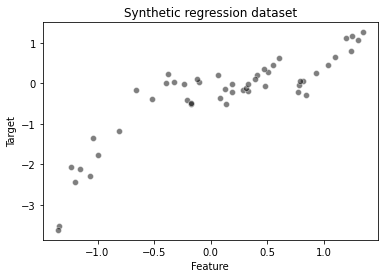

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

As we previously discussed, boosting will be based on assembling a sequence
of learners. We will start by creating a decision tree regressor. We will set
the depth of the tree so that the resulting learner will underfit the data.

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)

target_train_predicted = tree.predict(data_train)
target_test_predicted = tree.predict(data_test)

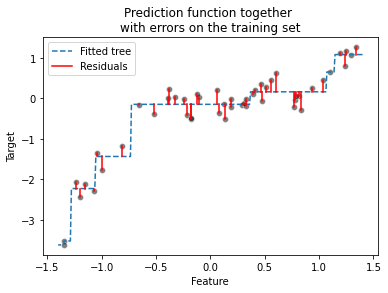

In [4]:
# plot the data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
# plot the predictions
line_predictions = plt.plot(data_test, target_test_predicted, "--")

# plot the residuals
for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"])
_ = plt.title("Prediction function together \nwith errors on the training set")

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p class="last">In the cell above, we manually edited the legend to get only a single label
for all the residual lines.</p>
</div>
Since the tree underfits the data, its accuracy is far from perfect on the
training data. We can observe this in the figure by looking at the difference
between the predictions and the ground-truth data. We represent these errors,
called "Residuals", by unbroken red lines.

Indeed, our initial tree was not expressive enough to handle the complexity
of the data, as shown by the residuals. In a gradient-boosting algorithm, the
idea is to create a second tree which, given the same data `data`, will try
to predict the residuals instead of the vector `target`. We would therefore
have a tree that is able to predict the errors made by the initial tree.

Let's train such a tree.

In [5]:
residuals = target_train - target_train_predicted

tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
tree_residuals.fit(data_train, residuals)

target_train_predicted_residuals = tree_residuals.predict(data_train)
target_test_predicted_residuals = tree_residuals.predict(data_test)

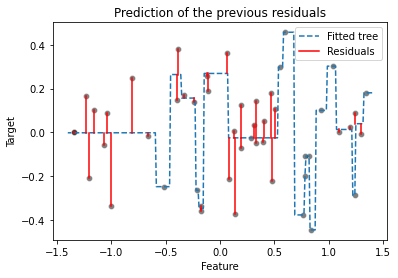

In [6]:
sns.scatterplot(x=data_train["Feature"], y=residuals, color="black", alpha=0.5)
line_predictions = plt.plot(data_test, target_test_predicted_residuals, "--")

# plot the residuals of the predicted residuals
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"])
_ = plt.title("Prediction of the previous residuals")

We see that this new tree only manages to fit some of the residuals. We will
focus on the last sample in `data_train` and explain how the predictions of
both trees are combined. Let's first select the last sample in `data_train`.

In [7]:
data_max = data_train.iloc[-1, 0]
target_true = target_train.iloc[-1]
target_true_residual = residuals.iloc[-1]

Let's plot the previous information and highlight our sample of interest.
Let's start by plotting the original data and the prediction of the first
decision tree.

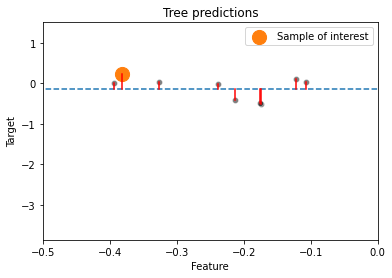

In [8]:
# Plot the previous information:
#   * the dataset
#   * the predictions
#   * the residuals

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
plt.plot(data_test, target_test_predicted, "--")
for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(data_max, target_true, label="Sample of interest",
            color="tab:orange", s=200)
plt.xlim([-0.5, 0])
plt.legend()
_ = plt.title("Tree predictions")

Now, let's plot the residuals information. We will plot the residuals
computed from the first decision tree and show the residual predictions.

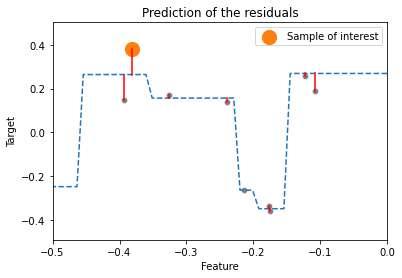

In [9]:
# Plot the previous information:
#   * the residuals committed by the first tree
#   * the residual predictions
#   * the residuals of the residual predictions

sns.scatterplot(x=data_train["Feature"], y=residuals,
                color="black", alpha=0.5)
plt.plot(data_test, target_test_predicted_residuals, "--")
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(data_max, target_true_residual, label="Sample of interest",
            color="tab:orange", s=200)
plt.xlim([-0.5, 0])
plt.legend()
_ = plt.title("Prediction of the residuals")

For our sample of interest, our initial tree is making an error (small
residual). When fitting the second tree, the residual in this case is
perfectly fitted and predicted. We will quantitatively check this prediction
using the fitted tree. First, let's check the prediction of the initial tree
and compare it with the true value.

In [10]:
print(f"True value to predict for f(x={data_max:.3f}) = {target_true:.3f}")

y_pred_first_tree = tree.predict([[data_max]])[0]
print(f"Prediction of the first decision tree for x={data_max:.3f}: "
      f"y={y_pred_first_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_tree:.3f}")

True value to predict for f(x=-0.382) = 0.238
Prediction of the first decision tree for x=-0.382: y=-0.145
Error of the tree: 0.383


As we visually observed, we have a small error. Now, we can use the second
tree to try to predict this residual.

In [11]:
print(f"Prediction of the residual for x={data_max:.3f}: "
      f"{tree_residuals.predict([[data_max]])[0]:.3f}")

Prediction of the residual for x=-0.382: 0.264


We see that our second tree is capable of predicting the exact residual
(error) of our first tree. Therefore, we can predict the value of `x` by
summing the prediction of the all trees in the ensemble.

In [12]:
y_pred_first_and_second_tree = (
    y_pred_first_tree + tree_residuals.predict([[data_max]])[0]
)
print(f"Prediction of the first and second decision trees combined for "
      f"x={data_max:.3f}: y={y_pred_first_and_second_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_and_second_tree:.3f}")

Prediction of the first and second decision trees combined for x=-0.382: y=0.120
Error of the tree: 0.118


We chose a sample for which only two trees were enough to make the perfect
prediction. However, we saw in the previous plot that two trees were not
enough to correct the residuals of all samples. Therefore, one needs to
add several trees to the ensemble to successfully correct the error.
(i.e. the second tree corrects the first tree's error, while the third tree
corrects the second tree's error and so on.)

We will compare the statistical performance of random-forest and gradient
boosting on the California housing dataset.

In [13]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_validate

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [ ]:
print("Gradient Boosting Decision Tree")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=200, n_jobs=2)
cv_results_rf = cross_validate(
    random_forest, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [ ]:
print("Random Forest")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_rf['test_score'].mean():.3f} +/- "
      f"{cv_results_rf['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_rf['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_rf['score_time'].mean():.3f} seconds")

In term of computation performance, the forest can be parallelized and will
benefit from using multiple cores of the CPU. In terms of scoring
performance, both algorithms lead to very close results.

However, we see that the gradient boosting is a very fast algorithm to
predict compared to random forest. This is due to the fact that gradient
boosting uses shallow trees. We will go into details in the next notebook
about the hyperparameters to consider when optimizing ensemble methods.